In [1]:
!pip install hplc-py
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=c69a69c298f58e40fcdda4029be3aed848f58212f865806f38e7b8d12e167b48
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib as mplt

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# File tools
from google.colab import drive
drive.mount('/content/drive')

#Data frames tools
import pandas as pd

#LHS sampling
from pyDOE import lhs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_excel("/content/drive/MyDrive/SunLab /data/XY Plots_from UPLC_only one raw material.xlsx")
df

,time,signal,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.016667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.033333,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.050000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.066667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
596,9.933333,-0.000091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,9.950000,-0.000093,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,9.966667,-0.000095,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599,9.983333,-0.000096,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'signal')

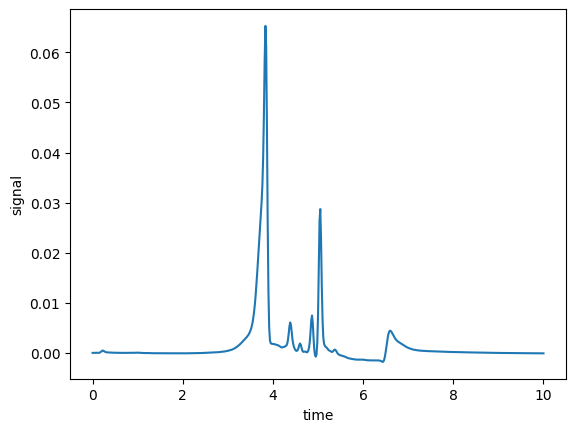

In [4]:
# plot - check to see if its right plot
xvals = df['time']
yvals = df['signal']

xvals = np.array(xvals)
yvals = np.array(yvals)

plt.plot(xvals, yvals)
plt.xlabel('time')
plt.ylabel('signal')


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

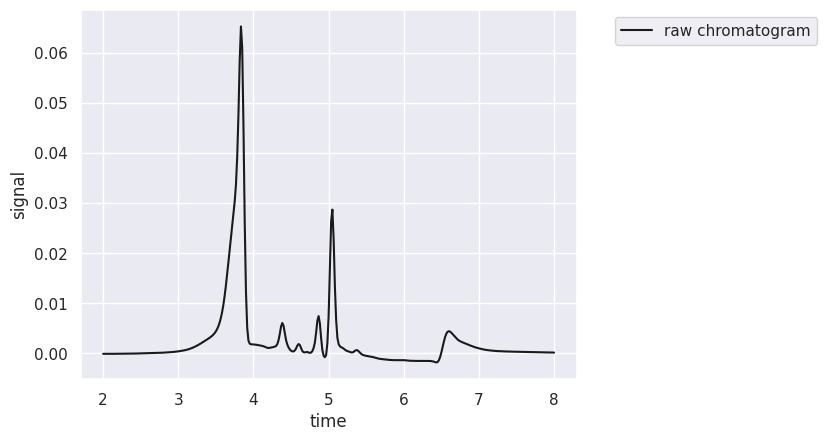

In [5]:
# Instantiate the Chromatogram class with the loaded chromatogram.
from hplc.quant import Chromatogram
chrom = Chromatogram(df)
chrom.crop([2, 8]) # crops to zoom on peak
# Show the chromatogram
chrom.show()

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

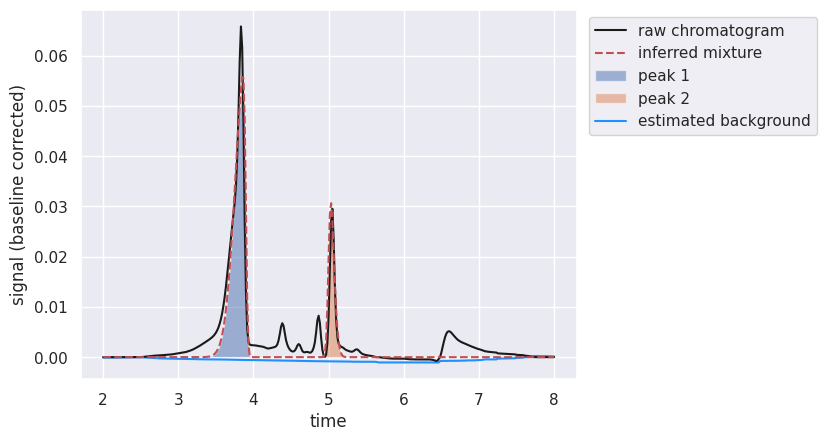

In [6]:
## Automatically detect and fit the peaks
#peaks = chrom.fit_peaks(buffer = 0) # <- This doesnt work
#peaks

chrom = Chromatogram(df, cols={'time':'time', 'signal':'signal'},time_window=[2, 8])
peaks = chrom.fit_peaks(prominence=0.3) #<- this worked...
chrom.show()

**METHOD**

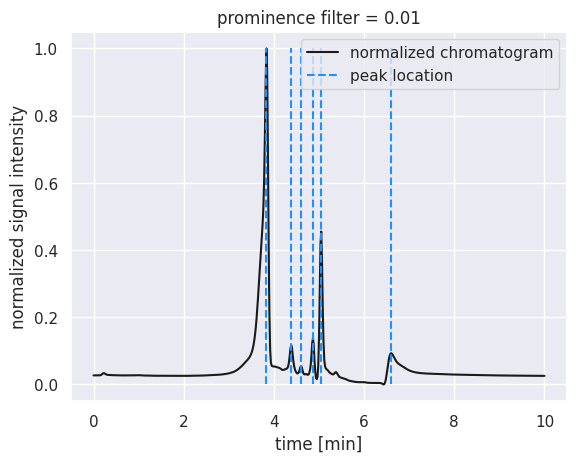

In [7]:
import scipy.signal

# Create a normalized signal
signal_norm = (df['signal'] - df['signal'].min()) / (df['signal'].max() - df['signal'].min())

# Find peaks with a low prominence filter of 0.01
peak_locations, _ = scipy.signal.find_peaks(signal_norm, prominence=0.01)
# Plot the  original trace and overlay vertical lines with location of peaks
plt.plot(df['time'], signal_norm, 'k-', label='normalized chromatogram')
plt.vlines(df['time'].values[peak_locations], 0, 1, linestyle='--',
           color='dodgerblue', label='peak location')
plt.xlabel('time [min]')
plt.ylabel('normalized signal intensity')
plt.title('prominence filter = 0.01')
plt.legend()

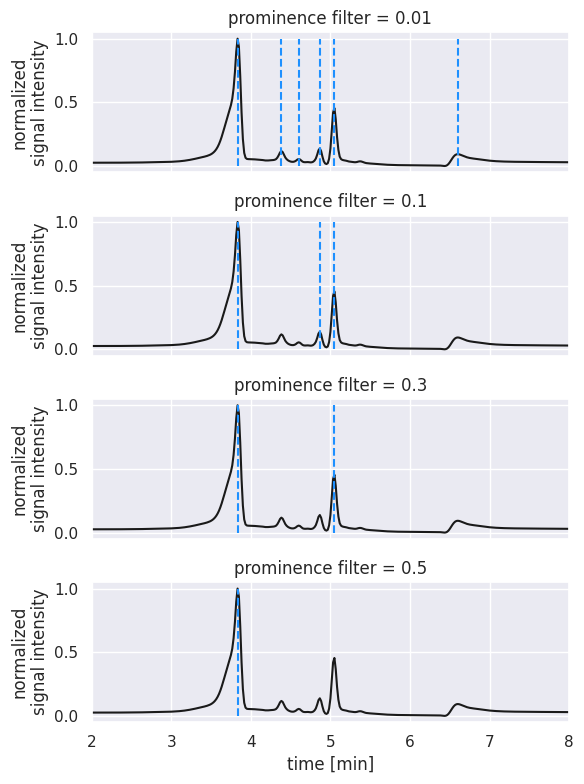

In [8]:
# Plot the  original trace and overlay vertical lines with location of peaks
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
for a in ax:
    a.plot(df['time'], signal_norm, 'k-')
    a.set_ylabel('normalized\nsignal intensity')

# Plot for a few prominecne values
for i, p in enumerate([0.01, 0.1, 0.3, 0.5]):
    peak_locations, _ = scipy.signal.find_peaks(signal_norm, prominence=p)
    ax[i].vlines(df['time'].values[peak_locations], 0, 1, linestyle='--', color='dodgerblue')
    ax[i].set_title(f'prominence filter = {p}')

# Add necessary labels
ax[3].set_xlabel('time [min]')
ax[2].set_xlim([2, 8])
plt.tight_layout()

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

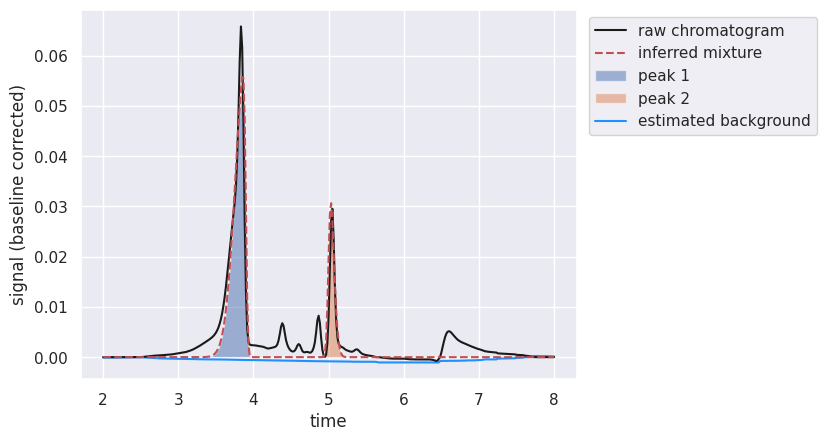

In [9]:
from hplc.quant import Chromatogram

# Load the signal trace as a Chromatogram object and crop between 2 and 8
chrom = Chromatogram(df, cols={'time':'time', 'signal':'signal'},
                     time_window=[2, 8])

# Pass a prominence filter, fit the peaks, and show the result
peaks = chrom.fit_peaks(prominence=0.2)
chrom.show()

In [28]:
# Automatically detect and fit the peaks
peaks = chrom.fit_peaks(prominence=0.2)
peaks

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


,retention_time,scale,skew,amplitude,area,peak_id
0,3.9,0.138619,-7.096754,0.010390,0.623398,1
0,5.0,0.059087,2.282213,0.002955,0.177299,2


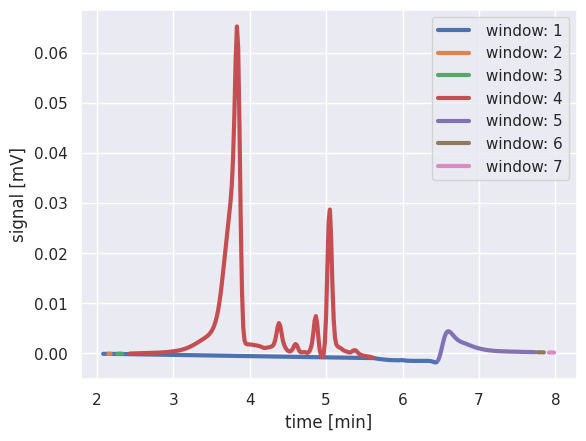

In [24]:
# Fit the peaks using a permissive prominence filter
window_df = chrom._assign_windows(prominence=0.01)

# Plot each window
for g, d in window_df.groupby('window_id'):
    plt.plot(d['time'], d['signal'], '-', lw=3, label=f' window: {g}')
plt.xlabel('time [min]')
plt.ylabel('signal [mV]')

plt.legend()

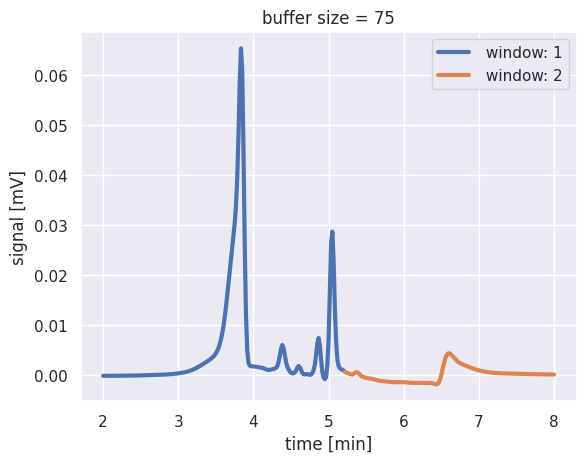

In [11]:
# Increase the buffer and plot the change in the peak window.
buffer = 75
window_df = chrom._assign_windows(prominence=0.01, buffer=buffer)

# Plot each window
for g, d in window_df.groupby('window_id'):
    plt.plot(d['time'], d['signal'], '-', lw=3, label=f' window: {g}')
plt.xlabel('time [min]')
plt.ylabel('signal [mV]')
plt.title(f'buffer size = {buffer}')
plt.legend()